In [1]:
import torch
from matplotlib import pyplot as plt

In [3]:
from miscellaneous.dataloader import FHA_Unsupervised
from miscellaneous.augumentation import FreqencyAugumentation, TimeAugumentation

In [77]:
import numpy as np
TIME_AUG = TimeAugumentation(256, 0.5, 0.1)
FREQ_AUG = FreqencyAugumentation(256,4,0.1)

def normalize(x:dict):
    x['EEG_Raw'] = (x['EEG_Raw'] - x['EEG_Raw'].mean(axis=-1, keepdims=True)) / (x['EEG_Raw'].std(axis=-1, keepdims=True) + 1e-6)
    return x

def FFT(x:dict):
    x['Freq'] = np.log(abs(np.fft.rfft(x['EEG_Raw'], axis=-1)) + 1e-6).astype(np.float32)
    return x

def augument(x:dict):
    x['EEG_Raw_Aug'] = TIME_AUG(x['EEG_Raw']).astype(np.float32)
    x['Freq_Aug'] = FREQ_AUG(x['Freq']).astype(np.float32)
    return x
def crop(x:dict):
    x['EEG_Raw'] = x['EEG_Raw'][0:1, 256:256*5]
    return x
 
def sample_channel(x:dict):
    x['EEG_Raw'] = x['EEG_Raw'][0:1, :]
    return x

def composer(*funcs):
    def compose(x):
        for f in funcs:
            x = f(x)
        return x
    return compose

In [78]:
NBatch = 64

preprocess = composer(normalize, FFT, augument)
dataset_config={'channels': 1, 'window_size':256*4, 'sampling_rate':256, 'access_pattern':'random', 'label':['ComorbidityLevelDesc', 'Age'], 'preprocess':preprocess}
dataset = FHA_Unsupervised(r"D:\EEG\FHA\Resting\001_a01_01\Annotations\Burnaby_Chunks.csv", r"D:\EEG\FHA\Resting\chunks", dataset_config)

from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=NBatch, shuffle=False, num_workers=0)

In [79]:
from miscellaneous.dataloader import FHA_Supervised
preprocess = composer(normalize, crop )
dataset_eval = FHA_Supervised(r"D:\EEG\FHA\Resting\001_a01_01", r"Annotations\Burnaby_Chunks.csv", r".hdf5",fileType='hd5', dataset_path=r"clips", keys=['EEG_Raw'], labels=['ComorbidityLevelDesc', 'Age'], preprocessor = preprocess,validation=False,filter='ComorbidityLevelDesc <0')

dataloader_eval = DataLoader(dataset_eval, batch_size=64, shuffle=False, num_workers=0)

In [ ]:
dataset[0]['EEG_Raw'].shape, dataset[0]['Freq'].shape, dataset[0]['EEG_Raw_Aug'].shape, dataset[0]['Freq_Aug'].shape, dataset[0]['ComorbidityLevelDesc']

In [ ]:
data = dataset[0]
plt.plot(data['Freq'][0])
plt.plot(data['Freq_Aug'][0])

In [57]:
from miscellaneous.loss import NTXentLoss_poly
from trainer import TFC_trainer_on_epoch

def on_batch_end( z):
    corr_matrix = np.corrcoef(z)
    plt.imshow(corr_matrix, interpolation='nearest')
    plt.colorbar()
    plt.title('Correlation Matrix')
    plt.savefig('correlation_matrix.png')
    plt.close()


#for faster training
def mutichannel_to_batch(x:dict):
    B, C, T = x['EEG_Raw'].shape
    x['EEG_Raw'] = x['EEG_Raw'].reshape(B * C, T)
    x['Freq'] = x['Freq'].reshape(B * C, T)
    x['EEG_Raw_Aug'] = x['EEG_Raw_Aug'].reshape(B * C, T)
    x['Freq_Aug'] = x['Freq_Aug'].reshape(B * C, T)
    return x

def test(model, dataloader,criteria,  device):
    model.train()
    model.cuda()
    for i, batch in enumerate(dataloader):
        batch = mutichannel_to_batch(batch)
        data_t = batch['EEG_Raw'].to(device)
        data_f = batch['Freq'].to(device)
        data_t_aug = batch['EEG_Raw_Aug'].to(device)
        data_f_aug = batch['Freq_Aug'].to(device)

        h_t, z_t, h_f, z_f = model(data_t, data_f)
        h_t_aug, z_t_aug, h_f_aug, z_f_aug = model(data_t_aug, data_f_aug)

        loss_t = criteria(h_t, h_t_aug)
        loss_f = criteria(h_f, h_f_aug)
        l_TF = criteria(z_t, z_f)
        break
    print(loss_t, loss_f, l_TF)

def validation(model, dataloader, device):
    representation = []
    label = []
    model.eval()
    model.to(device)
    for i, batch in enumerate(dataloader):
        data_t = batch['EEG_Raw'].to(device)
        y = batch['ComorbidityLevelDesc']
        h_t = model.encoder_t(data_t)
        representation.append(h_t.mean(dim=1).detach().cpu().numpy())
        label.append(y.detach().cpu().numpy())
        if i > 10 :
            break
    representation = np.concatenate(representation, axis=0)
    label = np.concatenate(label, axis=0)
    return representation, label
    
def train(model, dataloader, optimizer, device,batch_size=32, epochs=100, writer=None):
    loss_fn = NTXentLoss_poly(device,batch_size, 0.2, True)
    best_loss = 1e6
    
    for epoch in range(epochs):
        loss = TFC_trainer_on_epoch(model, dataloader, batch_size, optimizer, loss_fn, device)
        if best_loss > loss:
            best_loss = loss
            torch.save(model.state_dict(), 'results/model.pth')
        print(f'Epoch {epoch} Loss {loss}')
        r2 = age_regression(model, dataloader, device)
        if writer is not None:
            writer.add_scalar('Loss/train', loss, epoch)
            writer.add_scalar('R2/train', r2, epoch)
        
    writer.close()
        
def age_(model, dataloader_eval, device):
    model.eval()
    model.to(device)
    representation = []
    label = []
    for i, batch in enumerate(dataloader_eval):
        data_t = batch['EEG_Raw'].to(device)
        y = batch['Age']
        h_t = model.encoder_t(data_t)
        representation.append(h_t.mean(dim=1).detach().cpu().numpy())
        label.append(y.detach().cpu().numpy())
        if i > 5 :
            break
    representation = np.concatenate(representation, axis=0)
    label = np.concatenate(label, axis=0)
    return representation, label

def age_regression(model, dataloader_eval, device,scatter=False):
    representation, label = age_(model, dataloader_eval, device)
    print(f"sample size: {representation.shape[0]}")
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error, r2_score
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import make_pipeline

    gml = make_pipeline(StandardScaler(), LinearRegression())
    X_train, X_test, y_train, y_test = train_test_split(representation, label, test_size=0.2, random_state=42)
    gml.fit(X_train, y_train)
    y_pred = gml.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'MSE: {mse}, R2: {r2}')
    if scatter:
        plt.scatter(y_test, y_pred)
        plt.xlabel('True Age')
    return r2


In [21]:
from models import TFC

model = TFC(embeding_size=32,num_layers=2, num_heads=8)

In [22]:
#count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

62208

In [ ]:
from torch.utils.tensorboard import SummaryWriter

log_dir = 'results/exp1'
nepoch = 30
writer = SummaryWriter(log_dir=log_dir)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, dataloader, optimizer, 'cuda', batch_size=NBatch, epochs=nepoch, writer=writer)


sample size: 448
MSE: 444.1994172593653, R2: -0.2522397105872829


-0.2522397105872829

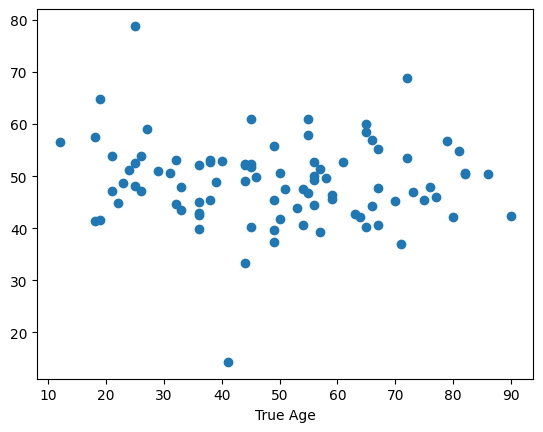

In [76]:
age_regression(model, dataloader_eval, 'cuda', scatter=True)
#representation, label = validation(model, dataloader_eval, 'cuda')

# Validation

In [ ]:
normalized_representation = (representation - representation.mean(axis=-1, keepdims=True)) / (representation.std(axis=-1, keepdims=True) + 1e-6)

In [ ]:
corr_matrix = np.corrcoef(normalized_representation[:64])
plt.imshow(corr_matrix, interpolation='nearest')
plt.colorbar()

In [ ]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

cosine_similarity(representation[0], representation[64])

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.imshow(representation.T, cmap='gray', interpolation='nearest')


In [ ]:
c = dataset_eval.data_csv['CMG'].to_numpy()

c:\Users\Zhenyu's PC\torch\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


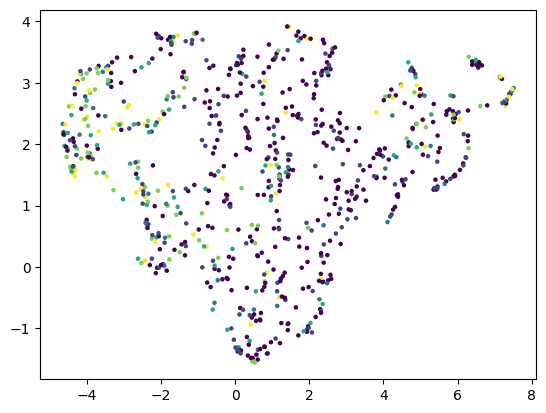

In [53]:
from matplotlib import pyplot as plt
from umap import UMAP

reducer = UMAP(n_components=2, n_neighbors=15, min_dist=0.05)
embedding = reducer.fit_transform(representation)

plt.scatter(embedding[:,0], embedding[:,1], c=label,s=5)

In [ ]:
plt.scatter(embedding[:500,0], embedding[:500,1], c=c[:500],s=10)